# Section I: Business Understanding

The annual StackOverflow's Developer's Survey contains questions and answers about StackOverflow users' jobs, skills, interests, aspirations, etc. This survey is compiled into a public dataset, which we will use in this notebook to analyze some aspects of the developer's career.

Based on this survey, we aim to answer the following questions about the data:

### 1. Which were the most used languages in 2020?

### 2. Does the language you work with affect your salary?

### 3. Does male developers earn more than females?

### 4. Which countries pays the most?

### 5. What features have the greatest impact on the developer's salary?


### Importing necessary packages

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDRegressor, LinearRegression
from sklearn.preprocessing import StandardScaler

%matplotlib inline

### Configuring plots

In [2]:
# configuring plots styles
CB91_Blue = '#2CBDFE'
CB91_Green = '#47DBCD'
CB91_Pink = '#F3A0F2'
CB91_Purple = '#9D2EC5'
CB91_Violet = '#661D98'
CB91_Amber = '#F5B14C'
color_list = [CB91_Blue, CB91_Pink, CB91_Green, CB91_Amber,
              CB91_Purple, CB91_Violet]
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=color_list)

sns.set(
  font='Franklin Gothic Book',
        rc={
 'axes.axisbelow': False,
 'axes.edgecolor': 'lightgrey',
 'axes.facecolor': 'None',
 'axes.grid': False,
 'axes.labelcolor': 'dimgrey',
 'axes.spines.right': False,
 'axes.spines.top': False,
 'figure.facecolor': 'white',
 'lines.solid_capstyle': 'round',
 'patch.edgecolor': 'w',
 'patch.force_edgecolor': True,
 'text.color': 'dimgrey',
 'xtick.bottom': False,
 'xtick.color': 'dimgrey',
 'xtick.direction': 'out',
 'xtick.top': False,
 'ytick.color': 'dimgrey',
 'ytick.direction': 'out',
 'ytick.left': False,
 'ytick.right': False})
sns.set_context("notebook", rc={"font.size":16,
                                "axes.titlesize":20,
                                "axes.labelsize":18})


# Section II: Data Understanding

### Gathering data

In [3]:
# The dataset can be downloaded at https://insights.stackoverflow.com/survey/?_ga=2.69654480.1154988598.1610264075-1259753100.1610264075
df = pd.read_csv('2020.csv') # replace here with your version
                                               # of the dataset
print(df.shape)
df.head()

(64461, 61)


,Respondent,MainBranch,Hobbyist,Age,Age1stCode,CompFreq,CompTotal,ConvertedComp,Country,CurrencyDesc,CurrencySymbol,DatabaseDesireNextYear,DatabaseWorkedWith,DevType,EdLevel,Employment,Ethnicity,Gender,JobFactors,JobSat,JobSeek,LanguageDesireNextYear,LanguageWorkedWith,MiscTechDesireNextYear,MiscTechWorkedWith,NEWCollabToolsDesireNextYear,NEWCollabToolsWorkedWith,NEWDevOps,NEWDevOpsImpt,NEWEdImpt,NEWJobHunt,NEWJobHuntResearch,NEWLearn,NEWOffTopic,NEWOnboardGood,NEWOtherComms,NEWOvertime,NEWPurchaseResearch,NEWPurpleLink,NEWSOSites,NEWStuck,OpSys,OrgSize,PlatformDesireNextYear,PlatformWorkedWith,PurchaseWhat,Sexuality,SOAccount,SOComm,SOPartFreq,SOVisitFreq,SurveyEase,SurveyLength,Trans,UndergradMajor,WebframeDesireNextYear,WebframeWorkedWith,WelcomeChange,WorkWeekHrs,YearsCode,YearsCodePro
0,1,I am a developer by profession,Yes,NaN,13,Monthly,NaN,NaN,Germany,European Euro,EUR,Microsoft SQL Server,Elasticsearch;Microsoft SQL Server;Oracle,"Developer, desktop or enterprise applications;...","Master’s degree (M.A., M.S., M.Eng., MBA, etc.)","Independent contractor, freelancer, or self-em...",White or of European descent,Man,"Languages, frameworks, and other technologies ...",Slightly satisfied,I am not interested in new job opportunities,C#;HTML/CSS;JavaScript,C#;HTML/CSS;JavaScript,.NET Core;Xamarin,.NET;.NET Core,Microsoft Teams;Microsoft Azure;Trello,Confluence;Jira;Slack;Microsoft Azure;Trello,No,Somewhat important,Fairly important,NaN,NaN,Once a year,Not sure,NaN,No,Often: 1-2 days per week or more,Start a free trial;Ask developers I know/work ...,Amused,Stack Overflow (public Q&A for anyone who codes),Visit Stack Overflow;Go for a walk or other ph...,Windows,2 to 9 employees,Android;iOS;Kubernetes;Microsoft Azure;Windows,Windows,NaN,Straight / Heterosexual,No,"No, not at all",NaN,Multiple times per day,Neither easy nor difficult,Appropriate in length,No,"Computer science, computer engineering, or sof...",ASP.NET Core,ASP.NET;ASP.NET Core,Just as welcome now as I felt last year,50.0,36,27
1,2,I am a developer by profession,No,NaN,19,NaN,NaN,NaN,United Kingdom,Pound sterling,GBP,NaN,NaN,"Developer, full-stack;Developer, mobile","Bachelor’s degree (B.A., B.S., B.Eng., etc.)",Employed full-time,NaN,NaN,NaN,Very dissatisfied,I am not interested in new job opportunities,Python;Swift,JavaScript;Swift,React Native;TensorFlow;Unity 3D,React Native,Github;Slack,Confluence;Jira;Github;Gitlab;Slack,NaN,NaN,Fairly important,NaN,NaN,Once a year,Not sure,NaN,No,NaN,NaN,Amused,Stack Overflow (public Q&A for anyone who code...,Visit Stack Overflow;Go for a walk or other ph...,MacOS,"1,000 to 4,999 employees",iOS;Kubernetes;Linux;MacOS,iOS,I have little or no influence,NaN,Yes,"Yes, definitely",Less than once per month or monthly,Multiple times per day,NaN,NaN,NaN,"Computer science, computer engineering, or sof...",NaN,NaN,Somewhat more welcome now than last year,NaN,7,4
2,3,I code primarily as a hobby,Yes,NaN,15,NaN,NaN,NaN,Russian Federation,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Objective-C;Python;Swift,Objective-C;Python;Swift,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Once a decade,NaN,NaN,No,NaN,NaN,NaN,Stack Overflow (public Q&A for anyone who codes),NaN,Linux-based,NaN,NaN,NaN,NaN,NaN,Yes,"Yes, somewhat",A few times per month or weekly,Daily or almost daily,Neither easy nor difficult,Appropriate in length,NaN,NaN,NaN,NaN,Somewhat more welcome now than last year,NaN,4,NaN
3,4,I am a developer by profession,Yes,25.0,18,NaN,NaN,NaN,Albania,Albanian lek,ALL,NaN,NaN,NaN,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",NaN,White or of European descent,Man,Flex time or a flexible schedule;Office enviro...,Slightly dissatisfied,"I’m not actively looking, but I am open to new...",NaN,NaN,NaN,NaN,NaN,NaN,No,NaN,Not at all important/not necessary,Curious about other opportunities;Wanting to w...,NaN,Once a year,Not sure,Yes,Yes,Occasionally: 1-2 days per quarter but less th...,NaN,NaN,Stack Overflow (public Q&A for anyone who code...,NaN,Lin

### Searching for missing values

In [4]:
df.isna().sum()

Respondent                0
MainBranch              299
Hobbyist                 45
Age                   19015
Age1stCode             6561
                      ...  
WebframeWorkedWith    22182
WelcomeChange         11778
WorkWeekHrs           23310
YearsCode              6777
YearsCodePro          18112
Length: 61, dtype: int64

We can see that there are a lot of missing values, we need to handle those values in order to build a model

### Analysing numerical features and distributions

In [5]:
df.describe()

,Respondent,Age,CompTotal,ConvertedComp,WorkWeekHrs
count,64461.000000,45446.000000,3.482600e+04,3.475600e+04,41151.000000
mean,32554.079738,30.834111,3.190464e+242,1.037561e+05,40.782174
std,18967.442360,9.585392,inf,2.268853e+05,17.816383
min,1.000000,1.000000,0.000000e+00,0.000000e+00,1.000000
25%,16116.000000,24.000000,2.000000e+04,2.464800e+04,40.000000
50%,32231.000000,29.000000,6.300000e+04,5.404900e+04,40.000000
75%,49142.000000,35.000000,1.250000e+05,9.500000e+04,44.000000
max,65639.000000,279.000000,1.111111e+247,2.000000e+06,475.000000


Among 60 features, only 3 are numerical that we can use (excluding ConvertedComp, our target variable, and CompTotal, for being highlly correlated with the target variable, we will get there)

findfont: Font family ['Franklin Gothic Book'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Franklin Gothic Book'] not found. Falling back to DejaVu Sans.


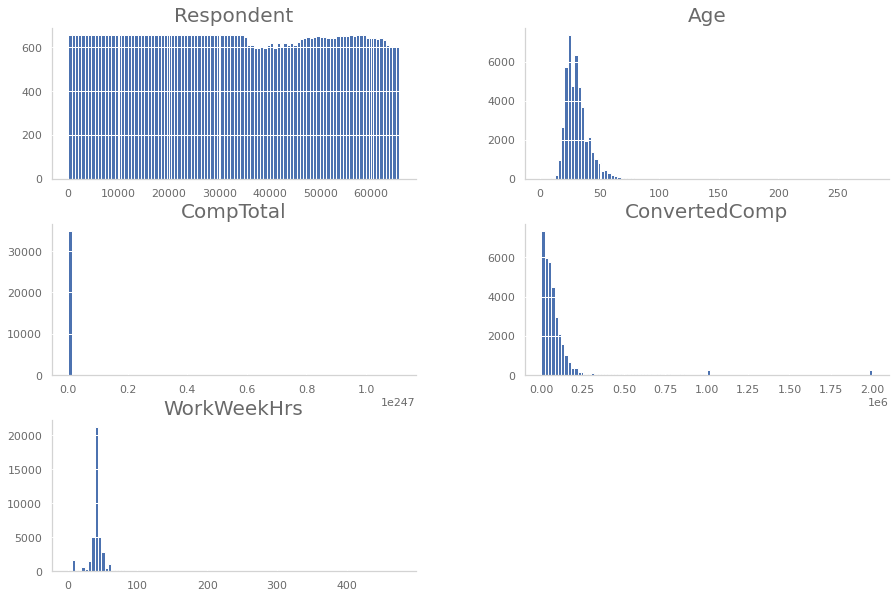

In [6]:
df.hist(bins=100, figsize=(15, 10));

We can see some skewness in Age and ConvertedComp

# Section III: Data Preparation

### Transforming data types

In [7]:
def extract_first_number_from_string(string):
    '''
    This function extracts the first positive integer found
    in a string, else, return None if don't found any number
    
    INPUT
    string - A string containing a number
    
    OUTPUT
    number - First number found in the string
    '''
    for char in string.split():
        if char.isdigit():
            return int(char)
    return None

In [8]:
# Those features contains pure numerical values and some strings like "Less than 1 year",
# therefore, we will handle than as numeric values to avoid having a huge number of categorical features
df['Age1stCode'] = df['Age1stCode'].astype(str).apply(extract_first_number_from_string)
df['YearsCode'] = df['YearsCode'].astype(str).apply(extract_first_number_from_string)
df['YearsCodePro'] = df['YearsCodePro'].astype(str).apply(extract_first_number_from_string)

### Cleaning the data

In [9]:
def clean_data(df):
    '''
    This function prepares the data to be applied to a model. It drops rows with NaN values
    in the target column, fills numerical NaNs with column mean, normalize the numerical features,
    convert categorical features into numerical features and split the data into X and y
    
    INPUT
    df - pandas DataFrame
    
    OUTPUT
    X - cleanned and prepared data, to be used as a model input
    y - model target variable
    '''
    df = df.dropna(subset=['ConvertedComp'])
    X = df.drop(columns=['ConvertedComp'])
    y = df['ConvertedComp']
    X = df.drop(columns=['CompTotal', 'ConvertedComp'])
    
    # Replacing NaNs with the column mean
    X = pd.concat([X.select_dtypes(include=['object']),
                  X.select_dtypes(exclude=['object']).fillna(X.select_dtypes(exclude=['object']).mean())],
                  axis=1)
    
    # Normalizing the data by column
    X = pd.concat([X.select_dtypes(include=['object']),
                  X.select_dtypes(exclude=['object']).apply(lambda x: x / max(x), axis=1)],
                  axis=1)
    
    # Transforming categorial features into numerical
    for col in X.select_dtypes(include=['object']):
        X = pd.concat([X.drop(columns=[col]), pd.get_dummies(X[col], prefix=col, prefix_sep='_', drop_first=True)],
                      axis=1)
    return X, y

In [10]:
X, y = clean_data(df)

# Section IV: Data Modeling

In this section, we will train a SGDRegressor to predict the salary, this model
was chosen because of it's partial_fit method, allowing to work with smaller
chunks of this big dataset.

With that model, we aim to analyze it's features scores, in order to discovery the most important features to predict one's salary

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
# For this large dataset, a model with partial_fit() is more suitable
model = SGDRegressor(max_iter=1000)
epochs = 10
train_size = len(X_train)
for epoch in range(epochs):
  chunk_size = 1/epochs
  init = int(epoch*chunk_size*train_size)
  end = int((epoch+1)*chunk_size*train_size)
  print('epoch', epoch)
  model.partial_fit(X_train[init: end], y_train[init: end])
model.score(X_test, y_test)

epoch 0
epoch 1
epoch 2
epoch 3
epoch 4
epoch 5
epoch 6
epoch 7
epoch 8
epoch 9


0.24132944703131298

The R² of the model is not great, it may indicate a overfitting because of the large number of features used, but, for the purpose of this analyze (getting the features importances) it may be valid.

# Section V: Evaluation


### 1. Which were the most used languages in 2020?

To answer this question, we will use the column "LanguageWorkedWith", which contains the languages that each respondent used, separed by semicolon (";"). Therefore, we need to separate each row into multiple rows of each language found, to count the occourrence of each one

In [13]:
def count_languages(languages_worked_with):
    '''
    Counts the occourrence of each language in the column "LanguageWorkedWith"
    and drop nan values (to allow value_counts)
    
    INPUT
    languages_worked_with - pandas series, the column "LanguageWorkedWith"
    
    OUTPUT
    count - value_counts() of each language
    '''
    count = []
    for row in languages_worked_with:
        languages = row.split(';')
        for language in languages:
            if language == 'nan':
              continue
            count.append(language)
    count = pd.Series(count).dropna().value_counts()
    return count

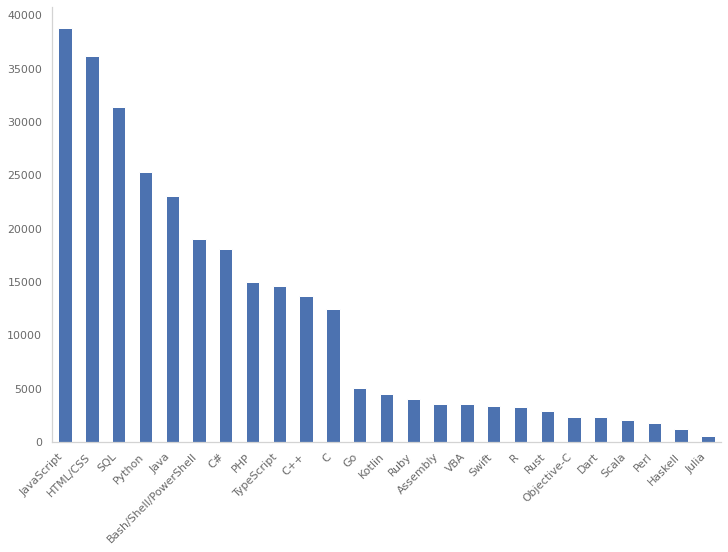

In [14]:
count = count_languages(df['LanguageWorkedWith'].astype(str))
count.plot.bar(figsize=(12, 8))
plt.xticks(rotation=45, ha='right', va='top');

The most used languages by the respondents in 2020 was JavaScript (JS), followed by HTML/CSS, SQL, Python and Java. All of these can be used for web development, and JS can even be used in mobile development. So, the growth of the web and mobile development area may explain this plot.

### 2. Does the language you work with affect your salary?

To answer this one, we will be measuring the mean salary for each language found in the dataset

findfont: Font family ['Franklin Gothic Book'] not found. Falling back to DejaVu Sans.


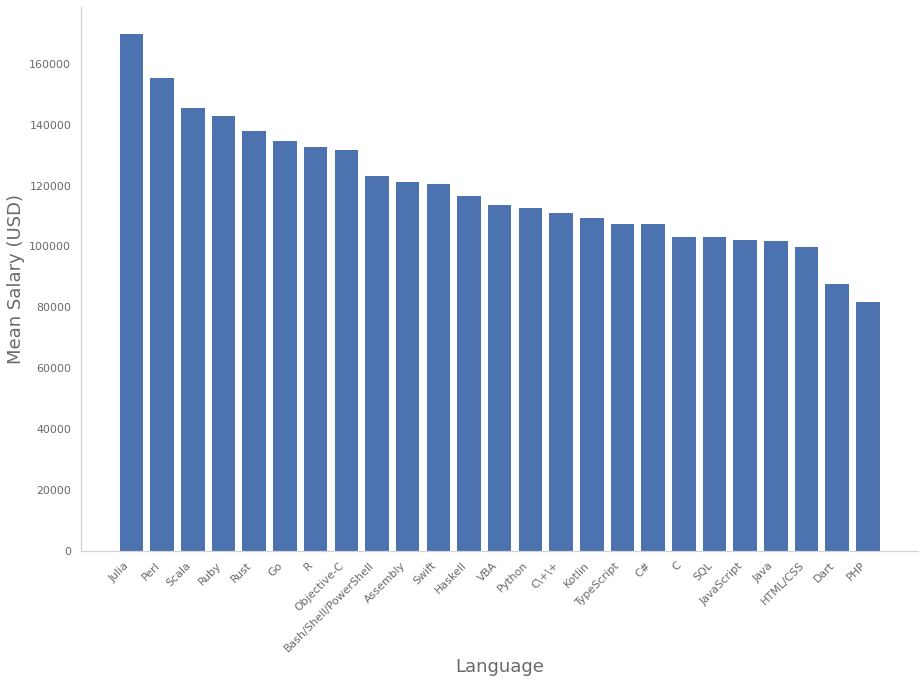

['Julia', 'Perl', 'Scala', 'Ruby', 'Rust']


In [15]:
languages = list(count.dropna().keys())

# We need to replace this occourrence to avoid error in contains()
languages[languages.index('C++')] = 'C\+\+'
salaries_by_lang = {}

# We need to drop the nan values to get the mean
aux_df = df.dropna(subset=['LanguageWorkedWith'])

# Getting the mean salary for each language
for language in languages:
  salaries_by_lang[language] = aux_df[aux_df['LanguageWorkedWith'].str.contains(language)]['ConvertedComp'].mean()

# Building the plot
plt.figure(figsize=(15, 10))
plt.bar(sorted(salaries_by_lang, key=salaries_by_lang.get, reverse=True), sorted(salaries_by_lang.values(), reverse=True))
plt.ylabel('Mean Salary (USD)')
plt.xlabel('Language')
plt.xticks(rotation=45, ha='right', va='top');
plt.show()
print(sorted(salaries_by_lang, key=salaries_by_lang.get, reverse=True)[:5])

This plot shows the mean annual salary, in USD, for the top 5 most paid languages. This shows that the language you work with can affect your salary, with the most popular languages not being among the most paid ones

### 3. Does male developers earn more than females?

In this question, we need to calculate the mean salary for each gender in the dataset.

First, let's analyze the gender distribution

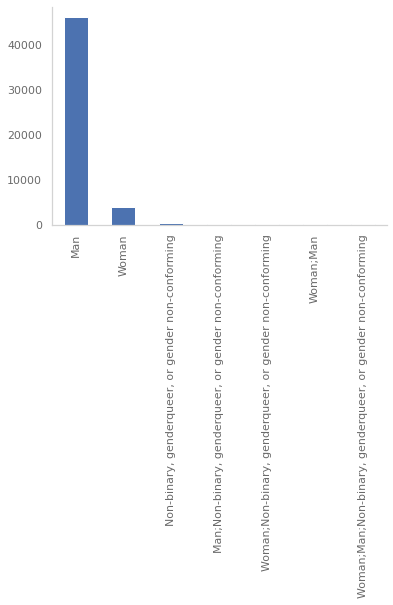

In [16]:
df['Gender'].dropna().value_counts().plot.bar();

In this figure, we can clearly see that most of the respondents were man, which may affect our analysis, because the statistical significance of the mean of other genders may not be good

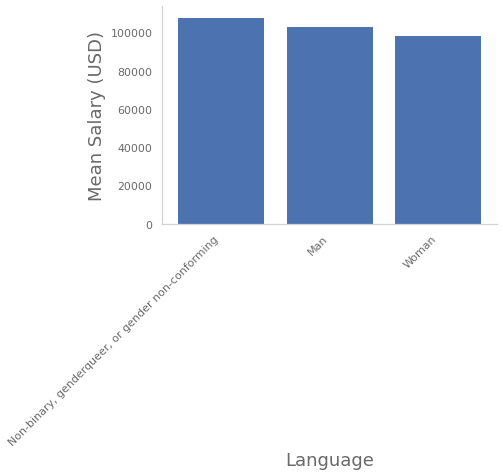

Man                                                            46013
Woman                                                           3844
Non-binary, genderqueer, or gender non-conforming                385
Man;Non-binary, genderqueer, or gender non-conforming            121
Woman;Non-binary, genderqueer, or gender non-conforming           92
Woman;Man                                                         76
Woman;Man;Non-binary, genderqueer, or gender non-conforming       26
Name: Gender, dtype: int64

In [17]:
salaries_by_gender = {}

# We need to drop the nan values to get the mean
aux_df = df.dropna(subset=['LanguageWorkedWith', 'Gender'])
genders = ['Woman', 'Man', 'Non-binary, genderqueer, or gender non-conforming']

# Getting the mean salary for each gender
for gender in genders:
  salaries_by_gender[gender] = aux_df[aux_df['Gender'].str.contains(gender)]['ConvertedComp'].mean()

# Building the plot
plt.bar(sorted(salaries_by_gender, key=salaries_by_gender.get, reverse=True), sorted(salaries_by_gender.values(), reverse=True))
plt.ylabel('Mean Salary (USD)')
plt.xlabel('Language')
plt.xticks(rotation=45, ha='right', va='top');
plt.show()
df['Gender'].value_counts()

This indicates that man, have a bigger mean annual salary than woman, and, non-binary people have the biggest salary ammong then. On the other hand, the number of samples for genders other than man are considerable smaller, so, this result may be biased

### 4. Which countries pays the most?

In this question, we will use a similar approach from the previous questions, but using median to avoid outliers

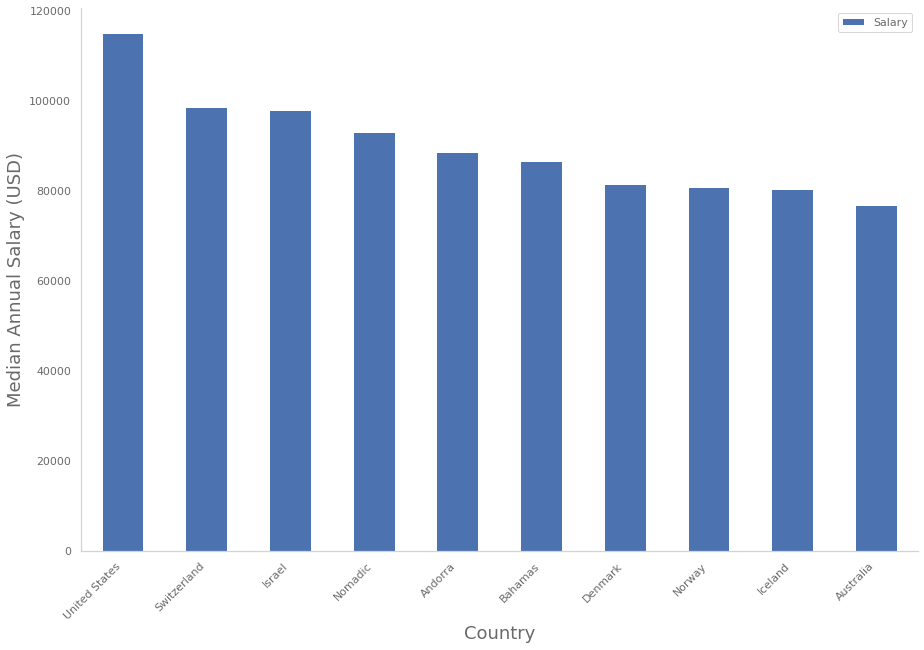

In [18]:
df[['ConvertedComp', 'Country']].dropna()\
        .groupby('Country').median()\
        .sort_values('ConvertedComp',ascending = False)\
        .nlargest(10, columns='ConvertedComp').plot.bar(figsize=(15, 10))
plt.ylabel('Median Annual Salary (USD)')
plt.legend(['Salary'])
plt.xticks(rotation=45, ha='right', va='top');

US have the greatest salaries for developers, followed by Switzerland, Israel, Normandic and Andorra.

### 5. What features have the greatest impact on the developer's salary?

To answer this question, we will use the numerical features correlation and the SGDRegressor feature weights to determine the most important features to predict the "ConvertedComp"

findfont: Font family ['Franklin Gothic Book'] not found. Falling back to DejaVu Sans.


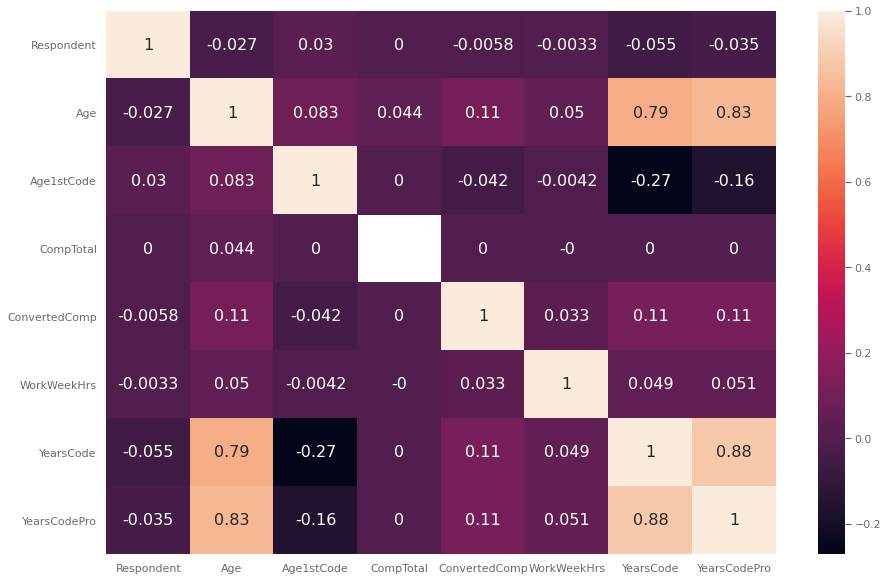

In [19]:
plt.figure(figsize=(15, 10))
sns.heatmap(df.corr(), annot=True);

This shows that, among the numerical features, Age, YearsCode and YearCodePro are the most correlated with "ConvertedComp"

In [87]:
coef_dict = {}
for coef, feat in zip(model.coef_, X_train.columns):
    coef_dict[feat] = coef
print(list(sorted(coef_dict, key=coef_dict.get, reverse=True))[:50])

['CompFreq_Weekly', 'Country_United States', 'CurrencyDesc_Pound sterling', 'CurrencySymbol_GBP', 'Country_United Kingdom', 'CurrencyDesc_United States dollar', 'CurrencySymbol_USD', 'OrgSize_10,000 or more employees', 'Respondent', 'Country_Australia', 'CurrencyDesc_Australian dollar', 'CurrencySymbol_AUD', 'CurrencyDesc_Canadian dollar', 'CurrencySymbol_CAD', 'Country_Canada', 'Country_Ireland', 'Country_Germany', 'CurrencyDesc_European Euro', 'CurrencySymbol_EUR', 'CurrencyDesc_Swiss franc', 'CurrencySymbol_CHF', 'Country_Norway', 'Country_Switzerland', 'CurrencyDesc_Norwegian krone', 'CurrencySymbol_NOK', 'JobSeek_I am not interested in new job opportunities', 'NEWLearn_Once every few years', 'EdLevel_Bachelor’s degree (B.A., B.S., B.Eng., etc.)', 'Ethnicity_White or of European descent', 'NEWJobHuntResearch_Read company media, such as employee blogs or company culture videos;Company reviews from third party sites (e.g. Glassdoor, Blind);Publicly available financial information (e.

With this, we have a list of the most important features, being CompFreq, Country, Currency, OrgSize and Education Level

Now, let's have a closer look at some of those features

#### YearsCode

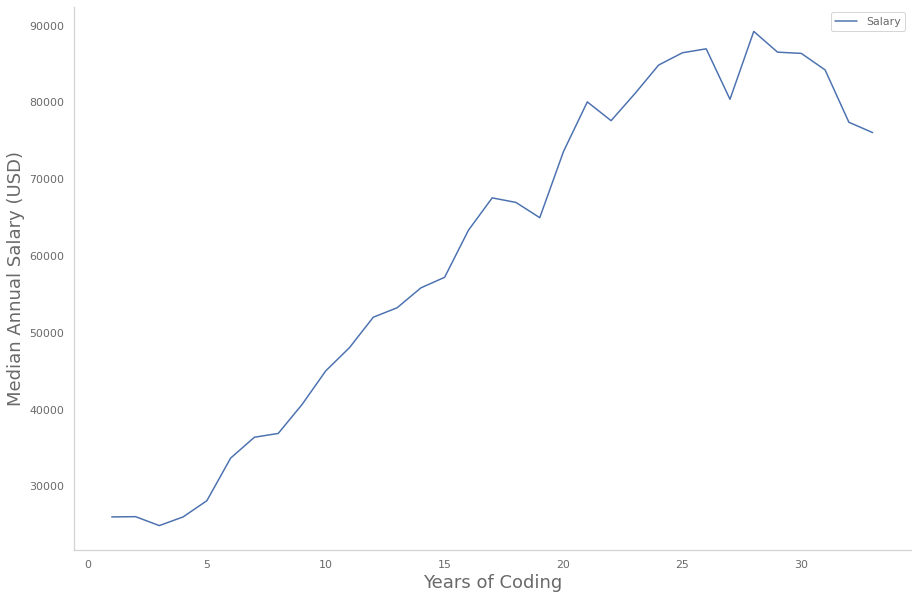

In [85]:
from scipy import stats
df[['ConvertedComp', 'YearsCode']].dropna()[np.abs(stats.zscore(df[['ConvertedComp', 'YearsCode']].dropna()['YearsCode'])) < 2]\
        .groupby('YearsCode').median().plot.line(figsize=(15, 10))
plt.legend(['Salary'])
plt.ylabel('Median Annual Salary (USD)')
plt.xlabel('Years of Coding');

In this plot, it is shown that the salary tends to increase along with YearsCode, with smaller salaries after approximate 27 years of experience, probably due to advanced age

#### EdLevel

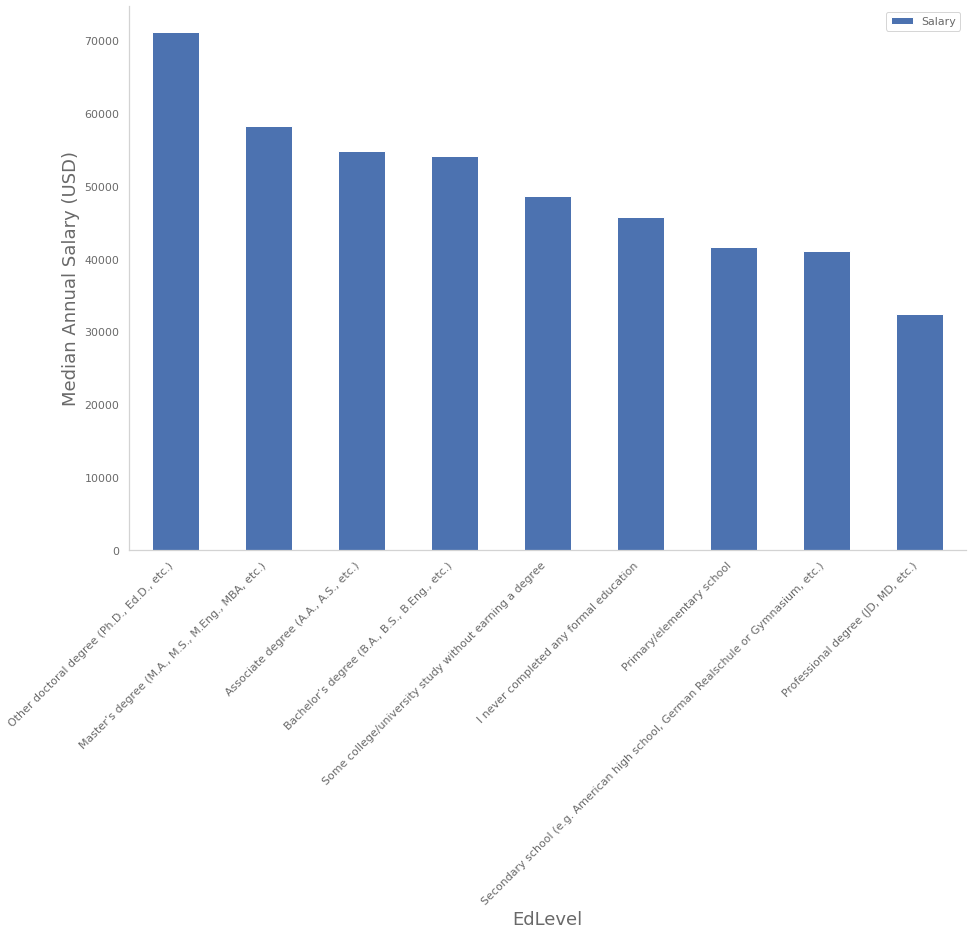

In [86]:
df[['ConvertedComp', 'EdLevel']].dropna()\
        .groupby('EdLevel').median()\
        .sort_values('ConvertedComp',ascending = False)\
        .nlargest(10, columns='ConvertedComp').plot.bar(figsize=(15, 10))
plt.ylabel('Median Annual Salary (USD)')
plt.xlabel('Education level')
plt.legend(['Salary'])
plt.xticks(rotation=45, ha='right', va='top');

This plot shows that higher education levels leads to higher salaries

#### OpSys

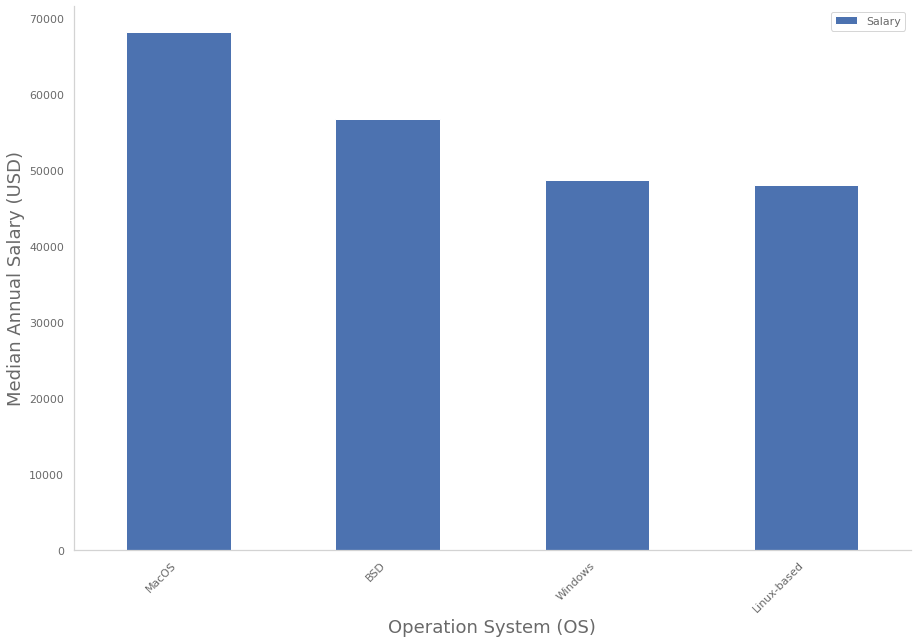

In [89]:
df[['ConvertedComp', 'OpSys']].dropna()\
        .groupby('OpSys').median()\
        .sort_values('ConvertedComp',ascending = False)\
        .nlargest(10, columns='ConvertedComp').plot.bar(figsize=(15, 10))
plt.ylabel('Median Annual Salary (USD)')
plt.xlabel('Operation System (OS)')
plt.legend(['Salary'])
plt.xticks(rotation=45, ha='right', va='top');

The above plot displays that MacOS and BSD lead to the greatests salaries in the dataset, with Windows and Linux with similar salaries between then